In [6]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.io import gfile, read_file, decode_png, encode_jpeg
from tensorflow.keras.utils import load_img, img_to_array, image_dataset_from_directory
from tensorflow.keras.applications import EfficientNetV2B0
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import ConfusionMatrixDisplay as cmd

In [2]:
train_path = "./images/train/"
val_path = "./images/validation/"
test_path = "./images/test/"

In [4]:
def Get_images_shapes(path: str):
    folders = []
    for file in gfile.listdir(path):
        folders.append(file)
    paths = []
    for folder in folders:
        for _dir in gfile.listdir(path + folder):
            paths.append(path + folder + "/" + _dir)
    
    height, width = [], []
    for img in paths:
        shape = img_to_array(load_img(img)).shape
        height.append(shape[0])
        width.append(shape[1])
        
    return (tf.math.reduce_mean(height).numpy(), tf.math.reduce_mean(width).numpy())

In [5]:
height_mean, width_mean = Get_images_shapes(train_path)
height_mean, width_mean

2024-04-10 18:22:35.646674: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5932 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4060 Ti, pci bus id: 0000:0b:00.0, compute capability: 8.9


(1081, 1298)

In [7]:
input_shape = (224, 224)

In [9]:
train_data = image_dataset_from_directory(train_path, label_mode="categorical", batch_size=None,
                                          image_size=input_shape, shuffle=True)
val_data = image_dataset_from_directory(val_path, label_mode="categorical", batch_size=None, 
                                        image_size=input_shape, shuffle=False)
test_data = image_dataset_from_directory(test_path, label_mode="categorical", batch_size=None, 
                                         image_size=input_shape, shuffle=False)

Found 3115 files belonging to 36 classes.
Found 351 files belonging to 36 classes.
Found 359 files belonging to 36 classes.


In [10]:
class_list = train_data.class_names

In [11]:
def Convert_png_to_jpeg(path):
    for folder in gfile.listdir(path):
        png_files = gfile.glob(path + folder + "/" + "**/*.png")
        for file in png_files:
            png_img = decode_png(read_file(file), channels=3)
            jpeg_img = encode_jpeg(png_img)
            original_name = file.split("/")[-1]
            new_name = original_name.replace(".png", ".jpeg")
            out_dir = file.replace(original_name, new_name)
            with gfile.GFile(out_dir, "wb") as f:
                f.write(jpeg_img.numpy())

        for file in png_files:
            gfile.remove(file)

Convert_png_to_jpeg("./images/")

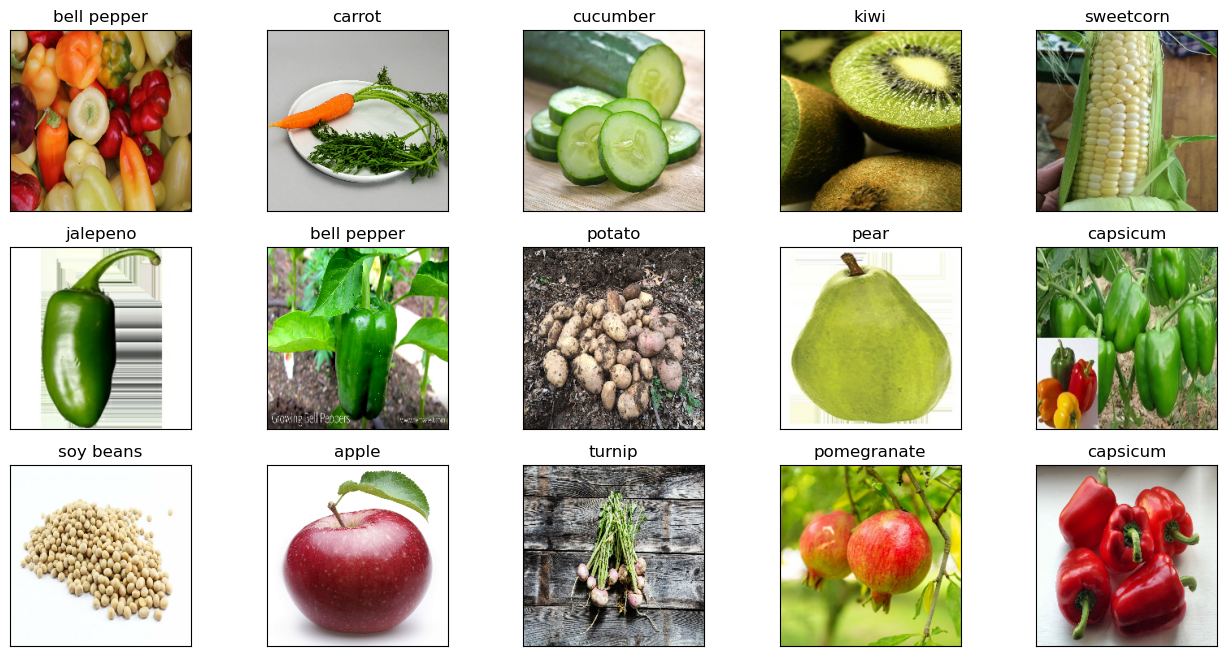

In [12]:
images, labels = next(iter(train_data.batch(15).take(1)))
images = images.numpy().astype("int")
labels = labels.numpy().astype("int")

fig, axs = plt.subplots(3, 5, figsize=(16, 8))
for idx, ax in enumerate(axs.flat):
    ax.imshow(images[idx])
    ax.set_title(class_list[labels[idx].argmax(axis=0)])
    ax.set_xticks([])
    ax.set_yticks([])
plt.show()

In [13]:
augments = tf.keras.models.Sequential([
    layers.RandomFlip(mode="horizontal"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
    layers.RandomContrast(0.2)
])

In [14]:
train_data = train_data.map(lambda x, y: (augments(x, training=True), y), num_parallel_calls=tf.data.AUTOTUNE)
train_data = train_data.shuffle(1000)
train_data = train_data.batch(32, num_parallel_calls=tf.data.AUTOTUNE)
train_data = train_data.prefetch(tf.data.AUTOTUNE)

val_data = val_data.batch(32, num_parallel_calls=tf.data.AUTOTUNE)
val_data = val_data.prefetch(tf.data.AUTOTUNE)

test_data = test_data.batch(32, num_parallel_calls=tf.data.AUTOTUNE)
test_data = test_data.prefetch(tf.data.AUTOTUNE)

In [15]:
base_model = EfficientNetV2B0(include_top=False, input_shape=input_shape + (3,))
base_model.trainable = False

24274472/24274472 [==============================] - 3s 0us/step


In [18]:
input_layer = layers.Input(shape=input_shape + (3,), name="Input_layer")
x = base_model(input_layer, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(1042, activation="relu")(x)
x = layers.Dropout(0.5)(x)
output = layers.Dense(len(class_list), activation="softmax", name="Output_layer")(x)

model = tf.keras.Model(inputs=input_layer, outputs=output)
model.summary(line_length=150, show_trainable=True)

Model: "model_1"
_________________________________________________________________________________________________________________________________________________________________
 Layer (type)                                                      Output Shape                                                Param #                Trainable  
 Input_layer (InputLayer)                                          [(None, 224, 224, 3)]                                       0                      Y          
                                                                                                                                                                 
 efficientnetv2-b0 (Functional)                                    (None, 7, 7, 1280)                                          5919312                N          
                                                                                                                                                                 
 global_ave

In [20]:
base_lr = 0.001
model.compile(optimizer=tf.keras.optimizers.Adamax(learning_rate=base_lr), 
              loss=tf.keras.losses.CategoricalCrossentropy(), metrics=["categorical_accuracy"])

ea_stop = tf.keras.callbacks.EarlyStopping(min_delta=0.001, patience=8, restore_best_weights=True)
tb_cb = tf.keras.callbacks.TensorBoard()
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=4)

In [21]:
hist = model.fit(train_data, validation_data=val_data, epochs=60, callbacks=[ea_stop, tb_cb, lr_scheduler])

Epoch 1/60


2024-04-10 18:35:28.280470: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8902
2024-04-10 18:35:28.440266: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-04-10 18:35:30.225440: I external/local_xla/xla/service/service.cc:168] XLA service 0x73e9a02778e0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-04-10 18:35:30.225456: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 4060 Ti, Compute Capability 8.9
2024-04-10 18:35:30.230962: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1712766930.290832   10605 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


98/98 [==============================] - 23s 75ms/step - loss: 2.1928 - categorical_accuracy: 0.4437 - val_loss: 0.8375 - val_categorical_accuracy: 0.8205 - lr: 0.0010
Epoch 2/60
98/98 [==============================] - 14s 70ms/step - loss: 1.1084 - categorical_accuracy: 0.6947 - val_loss: 0.5341 - val_categorical_accuracy: 0.8519 - lr: 0.0010
Epoch 3/60
98/98 [==============================] - 14s 70ms/step - loss: 0.9062 - categorical_accuracy: 0.7390 - val_loss: 0.4375 - val_categorical_accuracy: 0.8632 - lr: 0.0010
Epoch 4/60
98/98 [==============================] - 14s 69ms/step - loss: 0.8085 - categorical_accuracy: 0.7470 - val_loss: 0.3910 - val_categorical_accuracy: 0.8803 - lr: 0.0010
Epoch 5/60
98/98 [==============================] - 14s 71ms/step - loss: 0.7303 - categorical_accuracy: 0.7753 - val_loss: 0.3457 - val_categorical_accuracy: 0.8803 - lr: 0.0010
Epoch 6/60
98/98 [==============================] - 14s 70ms/step - loss: 0.6538 - categorical_accuracy: 0.7990 - va

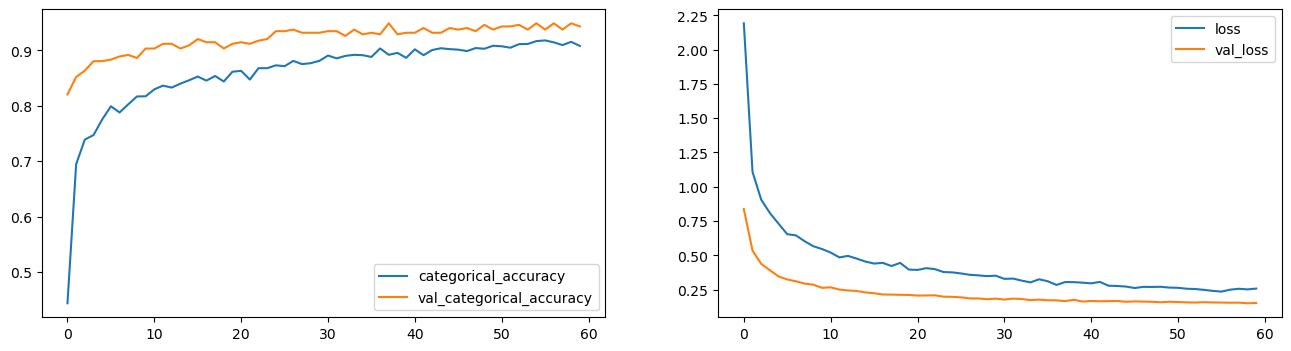

In [22]:
hist_df = pd.DataFrame(hist.history)
fig, axs = plt.subplots(1, 2, figsize=(16, 4))
hist_df[["categorical_accuracy", "val_categorical_accuracy"]].plot(ax=axs[0])
hist_df[["loss", "val_loss"]].plot(ax=axs[1])

plt.show()

In [23]:
model.evaluate(test_data)

12/12 [==============================] - 2s 149ms/step - loss: 0.1507 - categorical_accuracy: 0.9443


[0.150699645280838, 0.9442896842956543]

In [24]:
y_pred = model.predict(test_data)

12/12 [==============================] - 3s 115ms/step


In [25]:
labels = [label.numpy() for _, label in test_data]
for i in range(len(labels)):
    labels[i] = np.argmax(labels[i], axis=1)
labels = np.concatenate(labels)

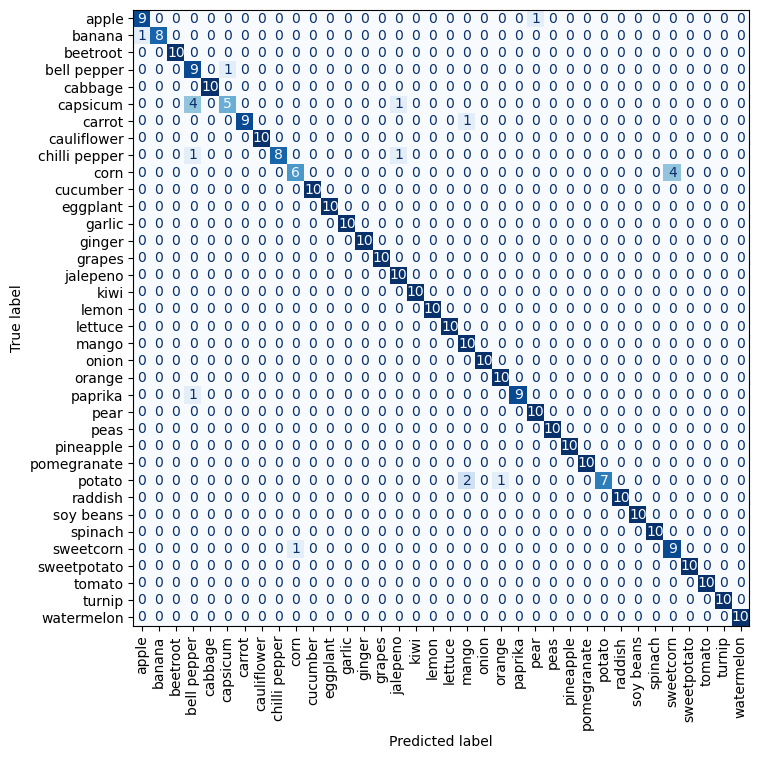

In [27]:
fig, ax = plt.subplots(figsize=(8, 8))
ax.grid(False)

cmd.from_predictions(labels, y_pred.argmax(axis=1), display_labels=class_list, 
                     xticks_rotation="vertical", cmap="Blues", ax=ax, colorbar=False)

In [31]:
len(base_model.layers)

270

In [36]:
base_model.trainable = True
fine_tuning_layers = 200
for layer in base_model.layers[:fine_tuning_layers]:
    layer.trainable = False

In [41]:
model.compile(optimizer=tf.keras.optimizers.Adamax(learning_rate=base_lr/10), 
              loss=tf.keras.losses.CategoricalCrossentropy(), metrics=["categorical_accuracy"])
ea_stop_fn = tf.keras.callbacks.EarlyStopping(min_delta=0.001, patience=4, restore_best_weights=True)
lr_scheduler_fn = tf.keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=2)

In [42]:
len(model.trainable_variables)

245

In [43]:
fine_tune_epochs = 10
total_epochs = 60 + fine_tune_epochs

In [44]:
hist_fn = model.fit(train_data, validation_data=val_data, epochs=total_epochs, 
                    initial_epoch=hist.epoch[-1], callbacks=[ea_stop, tb_cb, lr_scheduler])

Epoch 60/70
98/98 [==============================] - 54s 158ms/step - loss: 0.2534 - categorical_accuracy: 0.9027 - val_loss: 0.1477 - val_categorical_accuracy: 0.9544 - lr: 1.0000e-04
Epoch 61/70
98/98 [==============================] - 18s 110ms/step - loss: 0.2152 - categorical_accuracy: 0.9220 - val_loss: 0.1284 - val_categorical_accuracy: 0.9573 - lr: 1.0000e-04
Epoch 62/70
98/98 [==============================] - 18s 111ms/step - loss: 0.2015 - categorical_accuracy: 0.9268 - val_loss: 0.1327 - val_categorical_accuracy: 0.9544 - lr: 1.0000e-04
Epoch 63/70
98/98 [==============================] - 18s 112ms/step - loss: 0.1728 - categorical_accuracy: 0.9358 - val_loss: 0.1285 - val_categorical_accuracy: 0.9544 - lr: 1.0000e-04
Epoch 64/70
98/98 [==============================] - 18s 110ms/step - loss: 0.1752 - categorical_accuracy: 0.9364 - val_loss: 0.1294 - val_categorical_accuracy: 0.9544 - lr: 1.0000e-04
Epoch 65/70
98/98 [==============================] - 18s 111ms/step - loss:

In [45]:
model.evaluate(test_data)

12/12 [==============================] - 1s 108ms/step - loss: 0.1097 - categorical_accuracy: 0.9610


[0.1097472533583641, 0.961002767086029]

In [46]:
y_pred = model.predict(test_data)

12/12 [==============================] - 3s 118ms/step


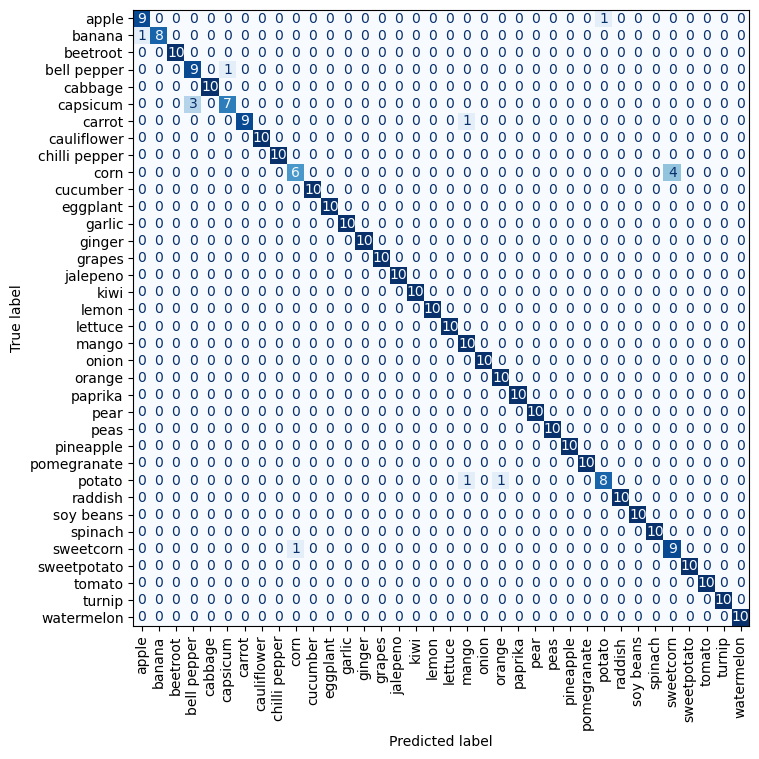

In [47]:
fig, ax = plt.subplots(figsize=(8, 8))
ax.grid(False)

cmd.from_predictions(labels, y_pred.argmax(axis=1), display_labels=class_list, 
                     xticks_rotation="vertical", cmap="Blues", ax=ax, colorbar=False)

In [48]:
model.save("./Models/efficenet_v2_b0_run1.keras")